<a href="https://colab.research.google.com/github/sankajithdjinasena/BrainTumorDetection/blob/main/Brain_Tumor_MRI_BioFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Brain Tumor MRI Classification using Deep Learning

**Team Name:** Deadlock  
**Competition:** BioFusion Hackathon – IEEE EMBS  
**Task:** Multiclass Brain Tumor Classification (MRI)

---



## 1. Problem Definition

### Clinical Relevance
Brain tumors are life-threatening conditions that require early and accurate diagnosis. MRI is the gold-standard imaging modality, but manual interpretation is time-consuming and prone to subjectivity.

### Objective
To classify brain MRI images into four categories:
- Glioma
- Meningioma
- Pituitary Tumor
- No Tumor

This model acts as a **clinical decision support tool**, not a replacement for clinicians.



## 2. Dataset Documentation

### Dataset Source
Brain Tumor MRI Dataset (Kaggle):  
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

### Dataset Size
- Training images: 5,714  
- Testing images: 1,311  

### Classes
Glioma, Meningioma, Pituitary, No Tumor


In [3]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## 3. Data Loading and Analysis


In [7]:
# Set paths (update according to your Drive)
train_dir = '/content/drive/MyDrive/BioFusion/data/Training'
test_dir = '/content/drive/MyDrive/BioFusion/data/Testing'

def create_df(directory):
    filepaths = []
    labels = []
    for folder in os.listdir(directory):
        for file in os.listdir(os.path.join(directory, folder)):
            filepaths.append(os.path.join(directory, folder, file))
            labels.append(folder)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df = create_df(train_dir)
test_df = create_df(test_dir)

print(train_df.shape, test_df.shape)


(5714, 2) (1311, 2)


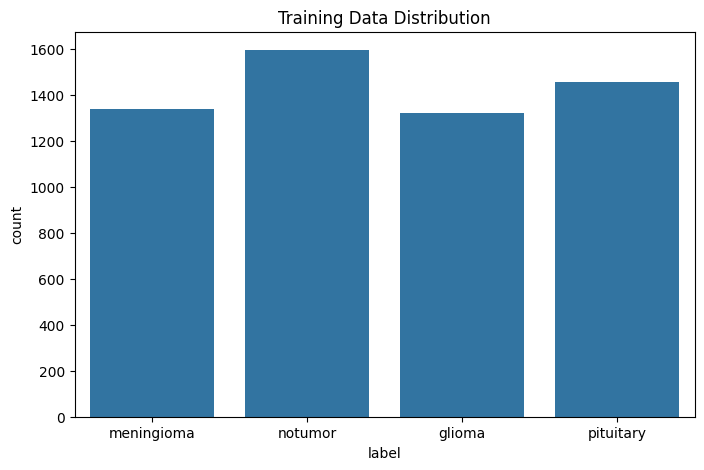

In [8]:
# Visualize class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=train_df)
plt.title('Training Data Distribution')
plt.show()



## 4. Data Preprocessing


In [9]:
# Split test into validation and final test
valid_df, ts_df = train_test_split(
    test_df, test_size=0.5, stratify=test_df['label'], random_state=42
)

img_size = (299, 299)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2]
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=img_size, class_mode='categorical',
    batch_size=batch_size
)

valid_data = test_gen.flow_from_dataframe(
    valid_df, x_col='filepath', y_col='label',
    target_size=img_size, class_mode='categorical',
    batch_size=batch_size
)

test_data = test_gen.flow_from_dataframe(
    ts_df, x_col='filepath', y_col='label',
    target_size=img_size, class_mode='categorical',
    batch_size=batch_size, shuffle=False
)


Found 5714 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.



## 5. Model Initialization & Pretrained Disclosure

### Pretrained Model
- Model: EfficientNetB3
- Source: TensorFlow / Keras
- Pretraining Dataset: ImageNet
- Weight Usage: Pretrained weights used


In [10]:
# Load EfficientNetB3 base model
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3)
)

base_model.trainable = False  # Feature extraction phase

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 299, 299,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 299, 299,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 299, 299,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 397,572 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)


## 6. Model Training


In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  5/179 ━━━━━━━━━━━━━━━━━━━━ 22:32 8s/step - accuracy: 0.3565 - loss: 1.6632


## 7. Training Logs and Curves


In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.show()



## 8. Model Evaluation


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test Accuracy: {test_acc*100:.2f}%')


In [ ]:
preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)
y_true = test_data.classes

print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))


In [ ]:
cm = confusion_matrix(y_true, y_pred) # Creating the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



## 9. Error Analysis & Limitations

- Minor confusion observed between Glioma and Meningioma classes
- Domain mismatch between ImageNet and MRI images
- Limited generalization to unseen MRI scanners



## 10. Reproducibility
- Random seed fixed
- Paths explicitly defined
- All cells runnable in Google Colab


In [ ]:
# Save final model
model.save('brain_tumor_efficientnetb3.h5')
